# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [3]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the afr dataset
from google.colab import drive
drive.mount('/content/drive')
!pip install numpy==1.16.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import re
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import sqlite3
import pandas as pd
import nltk
import string
# fix random seed for reproducibility
np.random.seed(7)

In [5]:
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con)


def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:28<00:00, 3028.69it/s]


In [22]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [23]:
X=np.asarray(preprocessed_reviews)
Y=np.asarray(final['Score'])
print(X.shape)
print(Y.shape)



from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.33)


print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)
print("="*100)
unique1, counts1 = np.unique(Y_train, return_counts=True)
print(unique1,counts1)
unique2, counts2 = np.unique(Y_test, return_counts=True)
print(unique2,counts2)
unique3, counts3 = np.unique(Y_cv, return_counts=True)
print(unique3,counts3)

(87773,)
(87773,)
(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)
[0 1] [ 6355 33045]
[0 1] [ 4665 24301]
[0 1] [ 3161 16246]


In [0]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train = tokenize.texts_to_sequences(X_train)
X_cv = tokenize.texts_to_sequences(X_cv)
X_test = tokenize.texts_to_sequences(X_test)

In [25]:
print(X_train[5])

[48, 243, 100, 1104, 4727, 12, 676, 6, 2, 2411, 125, 130, 1833, 31, 172, 943, 4436, 77, 1834, 87, 699, 7, 915, 1, 156, 90, 26, 1713, 7, 1, 48]


In [26]:
# truncate and/or pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_cv = sequence.pad_sequences(X_cv, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(39400, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

# LSTM MODEL WITH ONE HIDDEN LAYER

In [60]:
# create the model
embedding_vecor_length = 32
top_words=5000
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
model.fit(X_train, Y_train, nb_epoch=10, batch_size=64,validation_data=(X_cv,Y_cv))
# Final evaluation of the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 39400 samples, validate on 19407 samples
Epoch 1/10
39400/39400 [==============================] - 533s 14ms/step - loss: 0.2974 - acc: 0.8832 - val_loss: 0.2252 - val_acc: 0.9111
Epoch 2/10
39400/39400 [==============================] - 525s 13ms/step - loss: 0.1989 - acc: 0.9251 - val_loss: 0.2232 - val_acc: 0.9130
Epoch 3/10
39400/39400 [==============================] - 529s 13ms/step - loss: 0.1752 - acc: 0.9333 - val_loss: 0.2297 - val_acc: 0.9122
Epoch 4/10
39400/39400 [==============================] - 534s 14ms/step - loss: 0.1586 - acc: 0.9402 - val_loss: 0.2277 - val_acc: 0.9119
Epoch 5/10
39400/39400 [==============================] - 530s 13ms/step - loss: 0.1457 - acc: 0.9450 - val_loss: 0.2345 - val_acc: 0.9095
Epoch 6/10
39400/39400 [==============================] - 523s 13ms/step - loss: 0.1328 - acc: 0.9507 - val_loss: 0.2398 - val_acc: 0.9092
Epoch 7/10
39400/39400 [==============================] - 525s 13ms/step - loss: 0.1226 - acc: 0.9534 - val_loss: 0.

In [62]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: %.2f" % (scores[0]))


Accuracy: 90.58%
loss: 0.34


# LSTM MODEL WITH TWO HIDDEN LAYER

In [65]:
# create the model
embedding_vecor_length = 32
top_words=5000
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(100,recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           160032    
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
history21=model.fit(X_train, Y_train, nb_epoch=10, batch_size=64,validation_data=(X_cv,Y_cv))
# Final evaluation of the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 39400 samples, validate on 19407 samples
Epoch 1/10
39400/39400 [==============================] - 1068s 27ms/step - loss: 0.2892 - acc: 0.8865 - val_loss: 0.2219 - val_acc: 0.9137
Epoch 2/10
39400/39400 [==============================] - 1050s 27ms/step - loss: 0.1939 - acc: 0.9252 - val_loss: 0.2162 - val_acc: 0.9146
Epoch 3/10
39400/39400 [==============================] - 1046s 27ms/step - loss: 0.1719 - acc: 0.9347 - val_loss: 0.2313 - val_acc: 0.9145
Epoch 4/10
39400/39400 [==============================] - 1040s 26ms/step - loss: 0.1573 - acc: 0.9414 - val_loss: 0.2264 - val_acc: 0.9151
Epoch 5/10
39400/39400 [==============================] - 1057s 27ms/step - loss: 0.1439 - acc: 0.9477 - val_loss: 0.2395 - val_acc: 0.9129
Epoch 6/10
39400/39400 [==============================] - 1062s 27ms/step - loss: 0.1290 - acc: 0.9532 - val_loss: 0.2510 - val_acc: 0.9118
Epoch 7/10
39400/39400 [==============================] - 1065s 27ms/step - loss: 0.1187 - acc: 0.9573 - val_l

In [67]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: %.2f" % (scores[0]))

Accuracy: 90.39%
loss: 0.30


In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

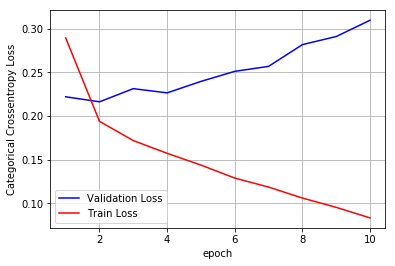

In [69]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history21.history['val_loss']
ty = history21.history['loss']
plt_dynamic(x, vy, ty, ax)

Above two models are clearly overfitting.so we will try with different architectures with various number of lstm cells,layers and dropouts to reduce the over fitting

# LSTM MODEL WITH THREE HIDDEN LAYER

In [27]:
# create the model
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 32
top_words=5000
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(30,recurrent_dropout=0.4,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20,return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

W0620 16:13:20.477221 140612696110976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 16:13:20.547567 140612696110976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 16:13:20.570302 140612696110976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 16:13:20.658961 140612696110976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0620 16:13:20.669114 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 30)           7560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 20)           4080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 20)           80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 20)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1240      
__________

In [29]:
history31=model.fit(X_train, Y_train, nb_epoch=2, batch_size=64,validation_data=(X_cv,Y_cv))
# Final evaluation of the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 39400 samples, validate on 19407 samples
Epoch 1/2
39400/39400 [==============================] - 1520s 39ms/step - loss: 0.2693 - acc: 0.8898 - val_loss: 0.2658 - val_acc: 0.8989
Epoch 2/2
39400/39400 [==============================] - 1522s 39ms/step - loss: 0.1901 - acc: 0.9269 - val_loss: 0.2201 - val_acc: 0.9112


In [30]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: %.2f" % (scores[0]))

Accuracy: 90.72%
loss: 0.22


In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

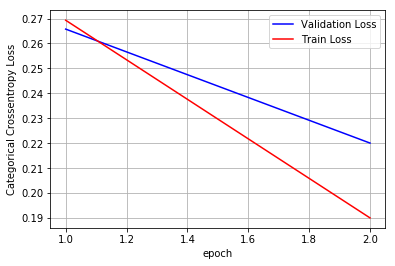

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,2+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history31.history['val_loss']
ty = history31.history['loss']
plt_dynamic(x, vy, ty, ax)

# LSTM WITH ONE HIDDEN LAYER WITH 30 LSTM CELLS

In [34]:
# create the model
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 32
top_words=5000
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(30))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 167,623
Trainable params: 167,623
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
history41=model.fit(X_train, Y_train, nb_epoch=5, batch_size=128,validation_data=(X_cv,Y_cv))
# Final evaluation of the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 39400 samples, validate on 19407 samples
Epoch 1/5
39400/39400 [==============================] - 251s 6ms/step - loss: 0.3272 - acc: 0.8717 - val_loss: 0.2268 - val_acc: 0.9085
Epoch 2/5
39400/39400 [==============================] - 249s 6ms/step - loss: 0.1867 - acc: 0.9274 - val_loss: 0.2177 - val_acc: 0.9140
Epoch 3/5
39400/39400 [==============================] - 249s 6ms/step - loss: 0.1548 - acc: 0.9415 - val_loss: 0.2194 - val_acc: 0.9149
Epoch 4/5
39400/39400 [==============================] - 249s 6ms/step - loss: 0.1346 - acc: 0.9499 - val_loss: 0.2247 - val_acc: 0.9128
Epoch 5/5
39400/39400 [==============================] - 249s 6ms/step - loss: 0.1165 - acc: 0.9581 - val_loss: 0.2449 - val_acc: 0.9101


In [36]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: %.2f" % (scores[0]))

Accuracy: 91.44%
loss: 0.24


In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

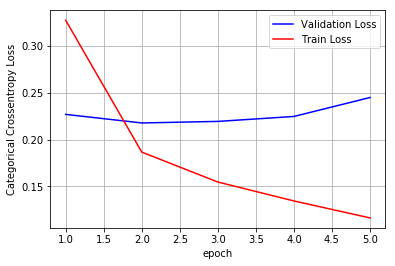

In [39]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,5+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history41.history['val_loss']
ty = history41.history['loss']
plt_dynamic(x, vy, ty, ax)

# LSTM WITH 2 HIDDEN LAYERS AND WITH 50,20 LSTM CELLS

In [40]:
# create the model
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 32
top_words=5000
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 50)           16600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 182,333
Trainable params: 182,333
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history51=model.fit(X_train, Y_train, nb_epoch=5, batch_size=128,validation_data=(X_cv,Y_cv))
# Final evaluation of the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 39400 samples, validate on 19407 samples
Epoch 1/5
39400/39400 [==============================] - 504s 13ms/step - loss: 0.4035 - acc: 0.8514 - val_loss: 0.2619 - val_acc: 0.8985
Epoch 2/5
39400/39400 [==============================] - 503s 13ms/step - loss: 0.2081 - acc: 0.9194 - val_loss: 0.2159 - val_acc: 0.9162
Epoch 3/5
39400/39400 [==============================] - 505s 13ms/step - loss: 0.1675 - acc: 0.9377 - val_loss: 0.2132 - val_acc: 0.9166
Epoch 4/5
39400/39400 [==============================] - 504s 13ms/step - loss: 0.1437 - acc: 0.9475 - val_loss: 0.2209 - val_acc: 0.9150
Epoch 5/5
39400/39400 [==============================] - 505s 13ms/step - loss: 0.1207 - acc: 0.9573 - val_loss: 0.2432 - val_acc: 0.9097


In [42]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: %.2f" % (scores[0]))

Accuracy: 91.09%
loss: 0.24


In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

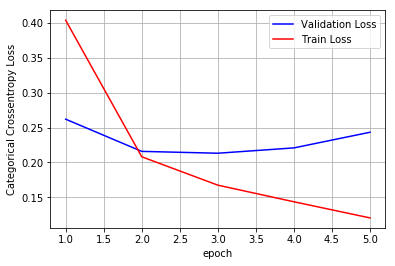

In [44]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,5+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history51.history['val_loss']
ty = history51.history['loss']
plt_dynamic(x, vy, ty, ax)

# CONCLUSIONS

In [4]:
from prettytable import PrettyTable

z = PrettyTable()

z.field_names = ["LSTM CELLS", "Train_accuracy","Validation_accuaracy","Test_accuracy","Train_loss","Validation_losss","Test_loss"]

z.add_row(["100", 0.9697,0.9038,0.9058,0.0835,0.3456,0.34])
z.add_row(["100-100", 0.9706,0.9019,0.9039,0.0835,0.3094,0.30])
z.add_row(["30-20-10", 0.9269,0.9112,0.9072,0.1901,0.2201,0.22])
z.add_row(["30", 0.9581,0.9101,0.9144,0.1165,0.2449,0.24])
z.add_row(["50-20", 0.9573,0.9097,0.9109,0.1207,0.2432,0.24])


print(z)

+------------+----------------+----------------------+---------------+------------+------------------+-----------+
| LSTM CELLS | Train_accuracy | Validation_accuaracy | Test_accuracy | Train_loss | Validation_losss | Test_loss |
+------------+----------------+----------------------+---------------+------------+------------------+-----------+
|    100     |     0.9697     |        0.9038        |     0.9058    |   0.0835   |      0.3456      |    0.34   |
|  100-100   |     0.9706     |        0.9019        |     0.9039    |   0.0835   |      0.3094      |    0.3    |
|  30-20-10  |     0.9269     |        0.9112        |     0.9072    |   0.1901   |      0.2201      |    0.22   |
|     30     |     0.9581     |        0.9101        |     0.9144    |   0.1165   |      0.2449      |    0.24   |
|   50-20    |     0.9573     |        0.9097        |     0.9109    |   0.1207   |      0.2432      |    0.24   |
+------------+----------------+----------------------+---------------+----------

Tried various LSTM arcitures on AMAZON FINE FOOD REVIEWS dataset

  1. All models are  overfitting easily with the increase in number of epochs.
    
  2. if we use only 2 epochs models are giving better results.

  3. I tried different dropout rates,different number of lstm cells in each layer to improve performance.
  
  4. plotted the train loss vs test loss.
  
  5.  Represented the  all architectures results using prettytable library.